In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [209]:
data = pd.read_csv('../malicious_phish.csv', index_col=False)
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


EDA 4

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


Finding all null values in the data

In [211]:
data.isnull().sum()

url     0
type    0
dtype: int64

EDA 5

In [212]:
data.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


Find all duplicated urls in the dataset (Data Cleaning 1)

In [213]:
duplicates = data.duplicated(subset='url')
print(len(list(filter(lambda x: x, duplicates))))

10072


Drop duplicated urls

In [214]:
unique = data.drop_duplicates(subset='url')
unique.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [215]:
unique.describe()

,url,type
count,641119,641119
unique,641119,4
top,br-icloud.com.br,benign
freq,1,428080


In [216]:
data = unique

Value counts of type attribute in dataset EDA 6

In [217]:
value_counts = data.type.value_counts()
value_counts

benign        428080
defacement     95308
phishing       94086
malware        23645
Name: type, dtype: int64

Plot a barplot for original dataset (EDA 1)

Text(0, 0.5, 'Count')

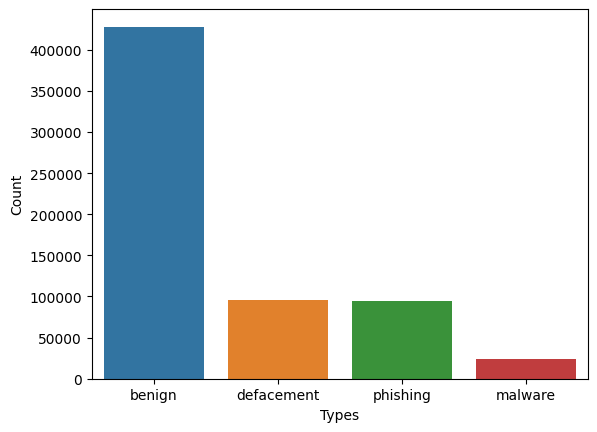

In [218]:
import seaborn as sns
labelX = value_counts.index
sns.barplot(x=labelX, y=value_counts)
plt.xlabel('Types')
plt.ylabel('Count')

Malware and Defacement can also be considered as Phishing websites as they are directed to false urls in the pursuit of planting or hacking data by some form of social engineering.

Data Cleaning 2

In [219]:
data['type'].replace({'malware': 'phishing', 'defacement': 'phishing'}, inplace=True)

Feature Engineering

Length of URL

In [220]:
data['length_of_url'] = data['url'].apply(lambda url: len(url) )
# data.head()

Get all special characters from URL

In [221]:
features = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for feature in features:
    data[feature] = data['url'].apply(lambda i: i.count(feature))
# data.head()

Check if the url is abnormal

In [222]:
from urllib.parse import urlparse
import re
def check_url(url):
    match = re.search(str(urlparse(url).hostname), url)
    if match:
        return 1
    else:
        return 0
data['abnormal_url'] = data['url'].apply(lambda i: check_url(i))
print(data.abnormal_url.value_counts())
# data.head()

0    463156
1    177963
Name: abnormal_url, dtype: int64


Check if it is a https (secure) website

In [223]:
def check_https(url):
    match = str(urlparse(url).scheme)
    if match=='https':
        return 1
    else:
        return 0
data['https_scheme'] = data.url.apply(lambda url: check_https(url))
print(data.https_scheme.value_counts())
# data.head()

0    625482
1     15637
Name: https_scheme, dtype: int64


Count number of numeric and alphabetic characters in the url string

In [224]:
def count_numbers(url):
    count = 0
    for itr in url:
        if itr.isnumeric():
            count+=1
    return count
def count_alphabets(url):
    count = 0
    for itr in url:
        if itr.isalpha():
            count+=1
    return count
data['count_numbers'] = data.url.apply(lambda url: count_numbers(url))
data['count_alphabets'] = data.url.apply(lambda url: count_alphabets(url))
# data.head()

Check if the url is valid or an IP address

In [225]:
#Taken from @sid321xan notebook from kaggle
def is_url_ip_address(url: str) -> bool:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
    
data['is_ip'] = data['url'].apply(lambda url: is_url_ip_address(url))
# data.head()

In [226]:
data.is_ip.value_counts()

0    628642
1     12477
Name: is_ip, dtype: int64

Get all domain level features

In [227]:
from tld import get_tld
def proc_tld(url):
    if url.startswith('http:'):
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=False)
    else:
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
    return len(res.subdomain), len(res.domain), len(res.tld), len(res.fld)

def proc_tld_url(entry):
    try:
        if entry['is_ip'] == 0:
            return proc_tld(entry['url'])
        return 'invalid', 'invalid', 'invalid', 'invalid'
    except Exception as e:
        return 'badurl', 'badurl', 'badurl', 'badurl'

data[['subdomain', 'domain', 'tld', 'fld']] = data.apply(lambda entry: proc_tld_url(entry), axis=1, result_type="expand")
# data.head()

In [228]:
data[['subdomain', 'domain', 'tld', 'fld']]

,subdomain,domain,tld,fld
0,0,9,6,16
1,0,7,3,11
2,0,10,3,14
3,3,14,2,17
4,0,19,3,23
...,...,...,...,...
651186,7,3,3,7
651187,5,8,3,12
651188,3,8,3,12
651189,2,9,3,13


Check if the url is a shortened url

In [229]:
#Taken from @habibmrad notebook from kaggle
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
data['short_url'] = data.url.apply(lambda url: Shortining_Service(url))
# data.head()


In [230]:
data.short_url.value_counts()

0    601703
1     39416
Name: short_url, dtype: int64

Get URL path length

In [231]:
def url_path(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
        path = ''
        if res.parsed_url.query:
            path = res.parsed_url.path + res.parsed_url.query
        else:
            path = res.parsed_url.path
        return len(path.split('/'))
    except:
        return None
data['url_path_length'] = data.url.apply(lambda url: url_path(url))
# data.head()

Ratio of characters to their length could be a better indicator as opposed to number of characters

In [232]:
data['numeric_ratio'] = data.apply(lambda entry: entry['count_numbers']/entry['length_of_url'], axis=1)
data['character_ratio'] = data.apply(lambda entry: entry['count_alphabets']/entry['length_of_url'], axis=1)
data.head()

,url,type,length_of_url,@,?,-,=,.,#,%,...,count_alphabets,is_ip,subdomain,domain,tld,fld,short_url,url_path_length,numeric_ratio,character_ratio
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,...,13,0,0,9,6,16,0,1.0,0.000000,0.812500
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,...,29,0,0,7,3,11,0,3.0,0.028571,0.828571
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,...,25,0,0,10,3,14,0,4.0,0.032258,0.806452
3,http://www.garage-pirenne.be/index.php?option=...,phishing,88,0,1,1,4,3,0,0,...,63,0,3,14,2,17,0,2.0,0.079545,0.715909
4,http://adventure-nicaragua.net/index.php?optio...,phishing,235,0,1,1,3,2,0,0,...,199,0,0,19,3,23,0,2.0,0.093617,0.846809


Description of generated dataset with engineered features

In [233]:
data.describe()

,length_of_url,@,?,-,=,.,#,%,+,$,...,//,abnormal_url,https_scheme,count_numbers,count_alphabets,is_ip,short_url,url_path_length,numeric_ratio,character_ratio
count,641119.00000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,...,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,641119.000000,628904.000000,641119.000000,641119.000000
mean,59.76247,0.002243,0.221391,1.561364,0.591642,2.193950,0.000884,0.398489,0.069463,0.000242,...,0.281310,0.277582,0.024390,5.371986,45.179165,0.019461,0.061480,3.384784,0.070980,0.777544
std,44.89459,0.054507,0.440003,2.984744,1.491306,1.491449,0.032580,4.166377,0.626015,0.023728,...,0.456609,0.447806,0.154257,11.630365,31.735030,0.138140,0.240209,1.659306,0.100210,0.116276
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,32.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,2.000000,0.000000,0.735294
50%,47.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,37.000000,0.000000,0.000000,3.000000,0.031250,0.800000
75%,76.00000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,6.000000,58.000000,0.000000,0.000000,4.000000,0.104651,0.857143
max,2175.00000,10.000000,20.000000,87.000000,51.000000,42.000000,6.000000,231.000000,37.000000,6.000000,...,9.000000,1.000000,1.000000,1204.000000,2141.000000,1.000000,1.000000,40.000000,1.000000,1.000000


Let's start with analysing the data

Barplot for the dataset yields in a very unbalanced dataset leaning towards benign

Text(0, 0.5, 'Count')

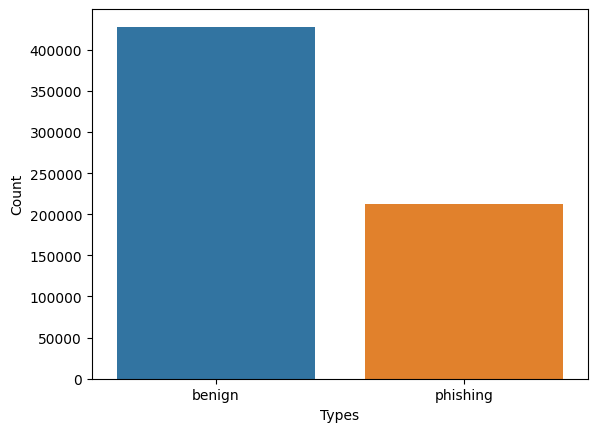

In [234]:
value_counts = data['type'].value_counts()
value_counts
labelX = value_counts.index
sns.barplot(x=labelX, y=value_counts)
plt.xlabel('Types')
plt.ylabel('Count')

In [235]:
benign_urls = data[data['type'] == 'benign']
benign_urls

,url,type,length_of_url,@,?,-,=,.,#,%,...,count_alphabets,is_ip,subdomain,domain,tld,fld,short_url,url_path_length,numeric_ratio,character_ratio
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,0,2,0,0,...,29,0,0,7,3,11,0,3.0,0.028571,0.828571
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,0,2,0,0,...,25,0,0,10,3,14,0,4.0,0.032258,0.806452
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,0,0,16,0,2,0,0,...,93,0,0,7,3,11,0,4.0,0.008475,0.788136
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,0,0,1,0,2,0,0,...,31,0,4,2,3,6,0,7.0,0.088889,0.688889
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,0,1,2,1,1,0,0,...,40,0,0,14,3,18,1,2.0,0.000000,0.869565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603177,imetrica.net/css/,benign,17,0,0,0,0,1,0,0,...,14,0,0,8,3,12,0,3.0,0.000000,0.823529
603178,www.idxband.com/telin/images/e-online.php,benign,41,0,0,1,0,3,0,0,...,34,0,3,7,3,11,0,4.0,0.000000,0.829268
603179,www.coffeewithsophieinc.com/media/system/js/ca...,benign,71,0,0,0,0,4,0,0,...,60,0,3,19,3,23,0,6.0,0.028169,0.845070
603180,conseguircreditos.webs.tl/,benign,26,0,0,0,0,2,0,0,...,23,0,17,4,2,7,0,2.0,0.000000,0.884615


In [236]:
phishing_urls = data[data['type'] == 'phishing']
phishing_urls

,url,type,length_of_url,@,?,-,=,.,#,%,...,count_alphabets,is_ip,subdomain,domain,tld,fld,short_url,url_path_length,numeric_ratio,character_ratio
0,br-icloud.com.br,phishing,16,0,0,1,0,2,0,0,...,13,0,0,9,6,16,0,1.0,0.000000,0.812500
3,http://www.garage-pirenne.be/index.php?option=...,phishing,88,0,1,1,4,3,0,0,...,63,0,3,14,2,17,0,2.0,0.079545,0.715909
4,http://adventure-nicaragua.net/index.php?optio...,phishing,235,0,1,1,3,2,0,0,...,199,0,0,19,3,23,0,2.0,0.093617,0.846809
8,http://www.pashminaonline.com/pure-pashminas,phishing,44,0,0,1,0,2,0,0,...,37,0,3,14,3,18,0,2.0,0.000000,0.840909
11,http://www.ikenmijnkunst.nl/index.php/expositi...,phishing,64,0,0,1,0,3,0,0,...,50,0,3,13,2,16,0,4.0,0.062500,0.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,0,0,0,0,3,0,0,...,21,0,7,3,3,7,0,4.0,0.307692,0.538462
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,0,0,2,0,2,0,0,...,29,0,5,8,3,12,1,5.0,0.159091,0.659091
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,0,0,0,0,2,0,0,...,33,0,3,8,3,12,1,5.0,0.071429,0.785714
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,0,0,0,0,2,0,0,...,36,0,2,9,3,13,0,3.0,0.000000,0.800000


In [237]:
print(benign_urls.shape)
print(phishing_urls.shape)

(428080, 29)
(213039, 29)


We resample the dataset using random undersampling (Data cleaning 3)

In [238]:
benign_urls_downsampled = benign_urls.sample(len(phishing_urls))
benign_urls_downsampled.shape

(213039, 29)

(Data Cleaning 4)

In [239]:
data = pd.concat([benign_urls_downsampled, phishing_urls])
value_counts = data['type'].value_counts()
value_counts

benign      213039
phishing    213039
Name: type, dtype: int64

Text(0, 0.5, 'Count')

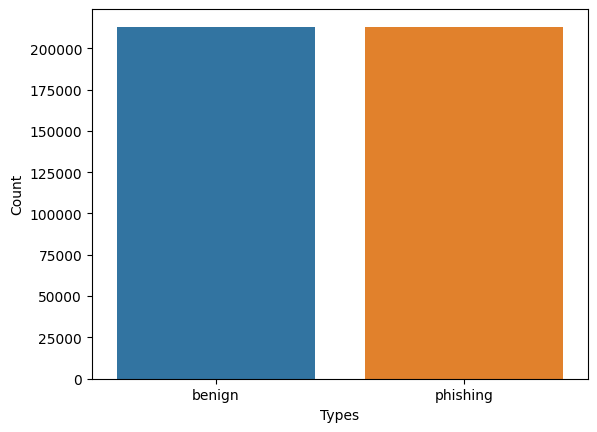

In [240]:
labelX = value_counts.index
sns.barplot(x=labelX, y=value_counts)
plt.xlabel('Types')
plt.ylabel('Count')

In [241]:
# data.to_csv('../downsampled_phishingDetection.csv')
# data = pd.read_csv('downsampled_phishingDetection.csv')
# data.shape

Convert categorical data to numeric Data Cleaning 10

In [242]:
temp = data
temp['type'].replace({'phishing': 1, 'benign': 0}, inplace=True)
value_counts = temp['type'].value_counts()
value_counts

0    213039
1    213039
Name: type, dtype: int64

EDA 2

/var/folders/wy/mkqdhcjj11dg3ydn76xg216r0000gn/T/ipykernel_16090/171250388.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp.corr(), linewidths=.5)


<AxesSubplot: >

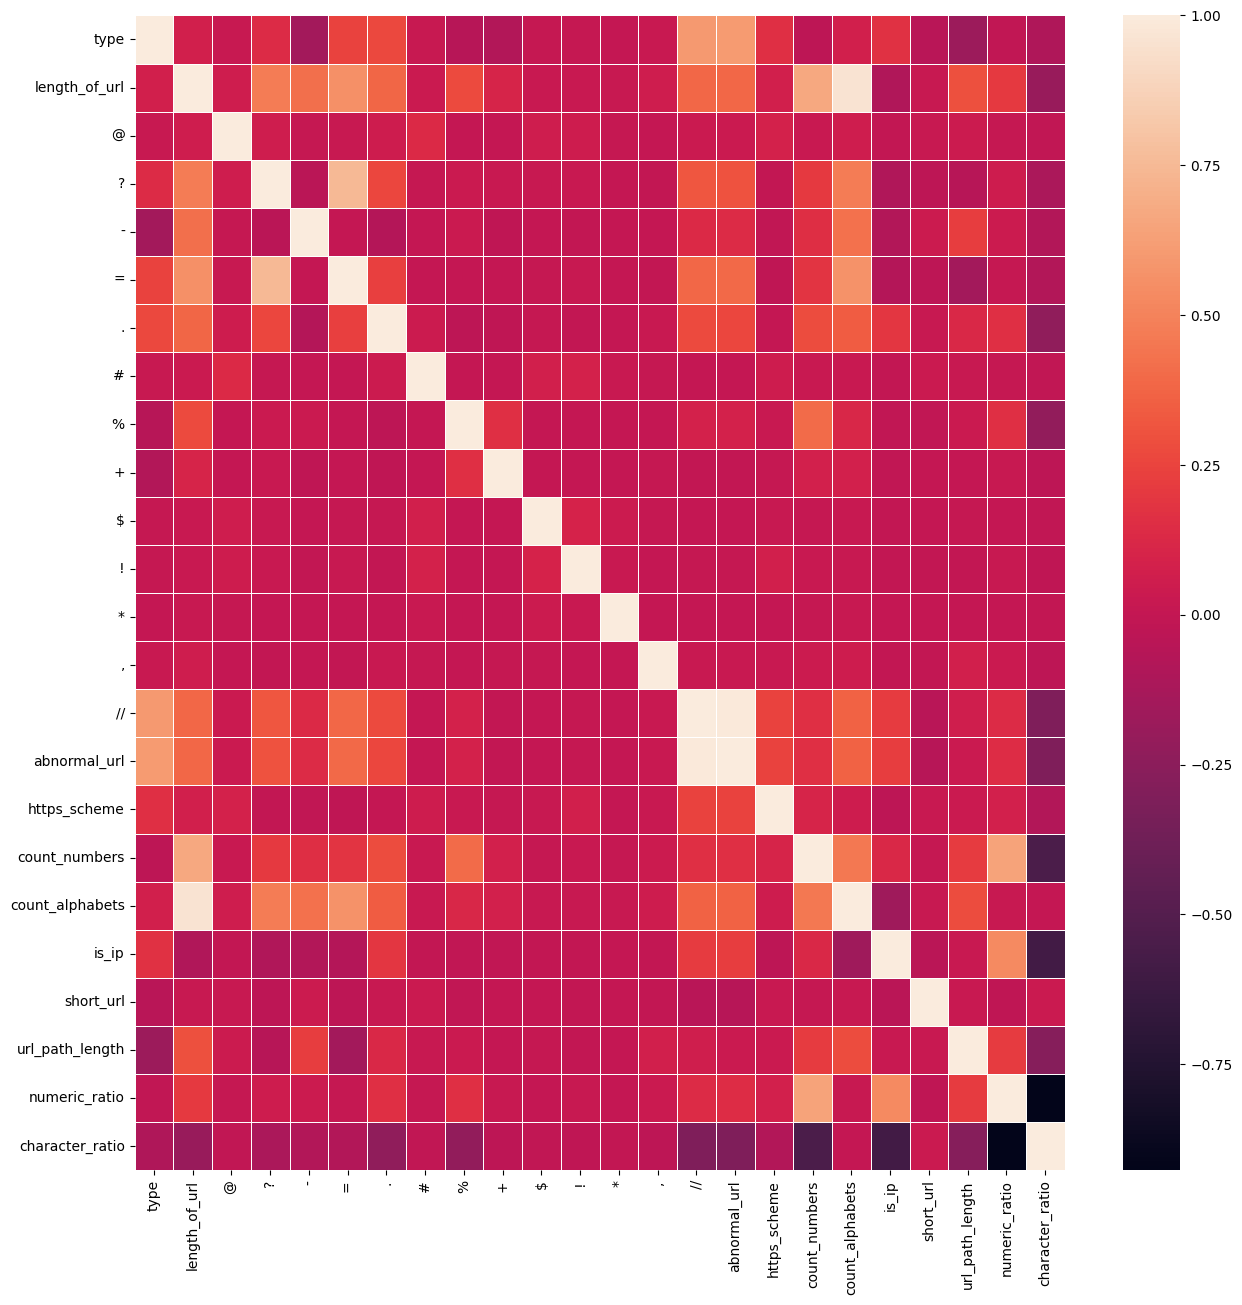

In [243]:
plt.figure(figsize=(15, 15))
sns.heatmap(temp.corr(), linewidths=.5)

EDA 3

In [244]:
data.isna().sum()

url                    0
type                   0
length_of_url          0
@                      0
?                      0
-                      0
=                      0
.                      0
#                      0
%                      0
+                      0
$                      0
!                      0
*                      0
,                      0
//                     0
abnormal_url           0
https_scheme           0
count_numbers          0
count_alphabets        0
is_ip                  0
subdomain              0
domain                 0
tld                    0
fld                    0
short_url              0
url_path_length    12201
numeric_ratio          0
character_ratio        0
dtype: int64

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426078 entries, 598628 to 651190
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   url              426078 non-null  object 
 1   type             426078 non-null  int64  
 2   length_of_url    426078 non-null  int64  
 3   @                426078 non-null  int64  
 4   ?                426078 non-null  int64  
 5   -                426078 non-null  int64  
 6   =                426078 non-null  int64  
 7   .                426078 non-null  int64  
 8   #                426078 non-null  int64  
 9   %                426078 non-null  int64  
 10  +                426078 non-null  int64  
 11  $                426078 non-null  int64  
 12  !                426078 non-null  int64  
 13  *                426078 non-null  int64  
 14  ,                426078 non-null  int64  
 15  //               426078 non-null  int64  
 16  abnormal_url     426078 non-null 

$ // abnormal_url is_ip
update as you go
plot the barplots for these features

1    142578
0     17798
Name: type, dtype: int64

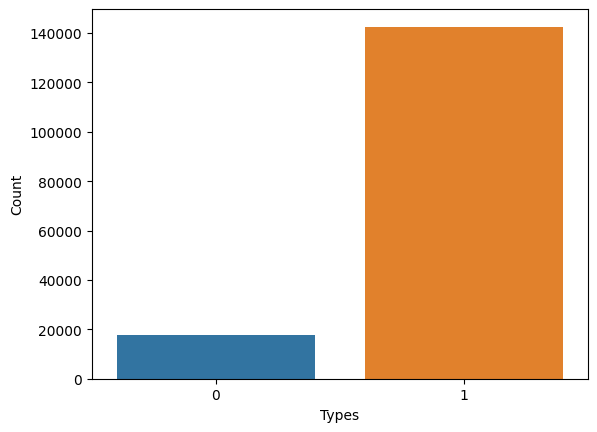

In [246]:
with_special_caharacters = data[data['//']>0]
sns.barplot(x=with_special_caharacters['type'].value_counts().index, y=with_special_caharacters['type'].value_counts())
plt.xlabel('Types')
plt.ylabel('Count')
with_special_caharacters['type'].value_counts()


1    63
0    19
Name: type, dtype: int64

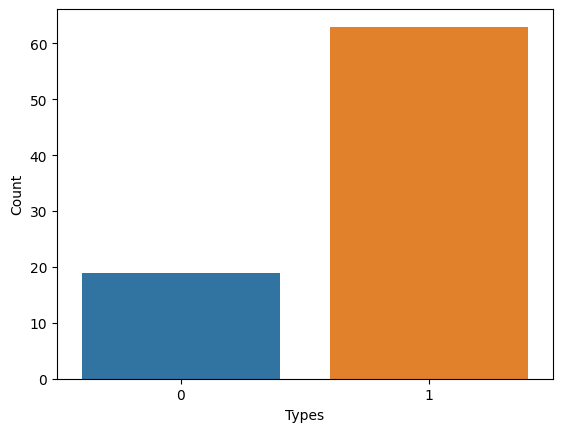

In [247]:
with_special_caharacters = data[data['$']>0]
sns.barplot(x=with_special_caharacters['type'].value_counts().index, y=with_special_caharacters['type'].value_counts())
plt.xlabel('Types')
plt.ylabel('Count')
with_special_caharacters['type'].value_counts()

1    142569
0     17470
Name: type, dtype: int64

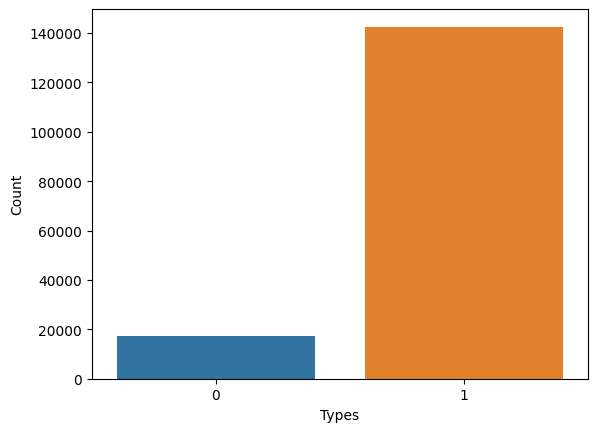

In [248]:
abnormal_url = data[data['abnormal_url']>0]
sns.barplot(x=abnormal_url['type'].value_counts().index, y=abnormal_url['type'].value_counts())
plt.xlabel('Types')
plt.ylabel('Count')
abnormal_url['type'].value_counts()

1    12273
0      111
Name: type, dtype: int64

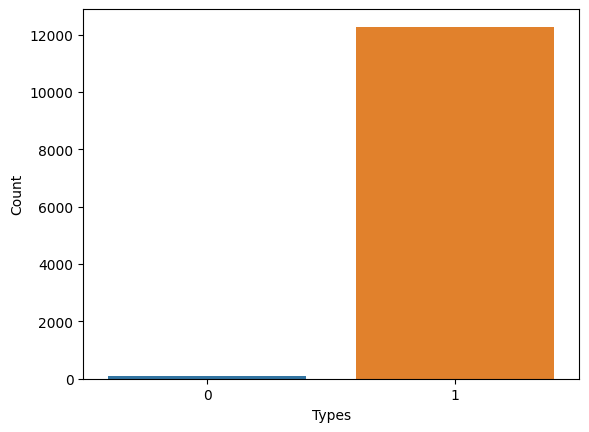

In [249]:
is_ip = data[data['is_ip']>0]
sns.barplot(x=is_ip['type'].value_counts().index, y=is_ip['type'].value_counts())
plt.xlabel('Types')
plt.ylabel('Count')
is_ip['type'].value_counts()

Handling missing values Data Cleaning 5

In [275]:
data['url_path_length'].replace({np.NaN: 0}, inplace=True)

In [276]:
data.isna().sum()

url                0
type               0
length_of_url      0
@                  0
?                  0
-                  0
=                  0
.                  0
#                  0
%                  0
+                  0
$                  0
!                  0
*                  0
,                  0
//                 0
abnormal_url       0
https_scheme       0
count_numbers      0
count_alphabets    0
is_ip              0
subdomain          0
domain             0
tld                0
fld                0
short_url          0
url_path_length    0
numeric_ratio      0
character_ratio    0
dtype: int64

Handling leading/trailing whitespaces Data Cleaning 6

In [251]:
# data['subdomain'] = data['subdomain'].str.strip()
# data['domain'] = data['domain'].str.strip()
# data['tld'] = data['tld'].str.strip()

Handling inconsistent capitalization Data Cleaning 6

In [252]:
# data['subdomain'] = data['subdomain'].str.lower()
# data['domain'] = data['domain'].str.lower()
# data['tld'] = data['tld'].str.lower()

Boxplot EDA 13

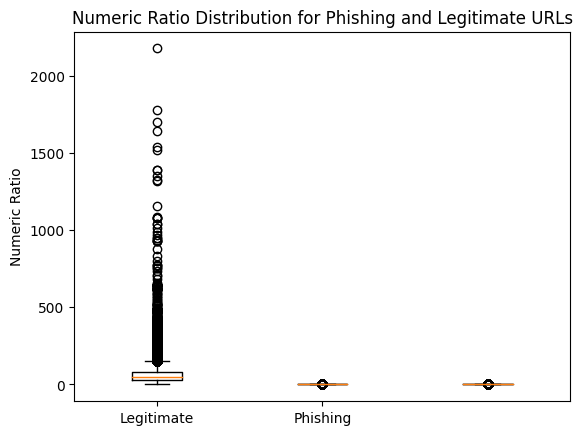

In [253]:
import matplotlib.pyplot as plt
# plt.boxplot([data[data['type'] == 0]['numeric_ratio'], data[data['type'] == 1]['numeric_ratio']])
plt.boxplot(data[['length_of_url', 'numeric_ratio', 'character_ratio']])
plt.title('Numeric Ratio Distribution for Phishing and Legitimate URLs')
plt.xticks([1, 2], ['Legitimate', 'Phishing'])
plt.ylabel('Numeric Ratio')
plt.show()

Removing outliers using z-score Data Cleaning 8

In [254]:
from scipy import stats
z_scores = stats.zscore(data[['length_of_url', 'numeric_ratio', 'character_ratio']])
# z_scores = stats.zscore(data[['character_ratio']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
# print(data[filtered_entries].shape)
# data.shape
data[filtered_entries].describe()

,type,length_of_url,@,?,-,=,.,#,%,+,...,//,abnormal_url,https_scheme,count_numbers,count_alphabets,is_ip,short_url,url_path_length,numeric_ratio,character_ratio
count,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,...,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,405376.000000,401404.000000,405376.000000,405376.000000
mean,0.490204,57.278569,0.002393,0.237387,1.408288,0.701346,2.254218,0.001073,0.108642,0.050440,...,0.361405,0.357281,0.033998,3.859158,44.310460,0.010265,0.058144,3.268293,0.056790,0.789344
std,0.499905,33.926179,0.051513,0.446258,2.732435,1.614723,1.284113,0.033338,1.170308,0.524902,...,0.488131,0.479199,0.181224,6.136599,25.310489,0.100793,0.234015,1.619593,0.078077,0.091111
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.410256
25%,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,2.000000,0.000000,0.746032
50%,0.000000,47.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,37.000000,0.000000,0.000000,3.000000,0.025000,0.800000
75%,1.000000,77.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,6.000000,59.000000,0.000000,0.000000,4.000000,0.087719,0.854545
max,1.000000,196.000000,4.000000,20.000000,47.000000,19.000000,28.000000,2.000000,51.000000,36.000000,...,4.000000,1.000000,1.000000,73.000000,180.000000,1.000000,1.000000,25.000000,0.378378,1.000000


Scaling numeric features to the same range using MinMaxScaler Data Cleaning 9

In [255]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['length_of_url', 'url_path_length', 'numeric_ratio', 'character_ratio']] = scaler.fit_transform(data[['length_of_url', 'url_path_length', 'numeric_ratio', 'character_ratio']])

Violin Plot on numeric ratio and Type EDA 7

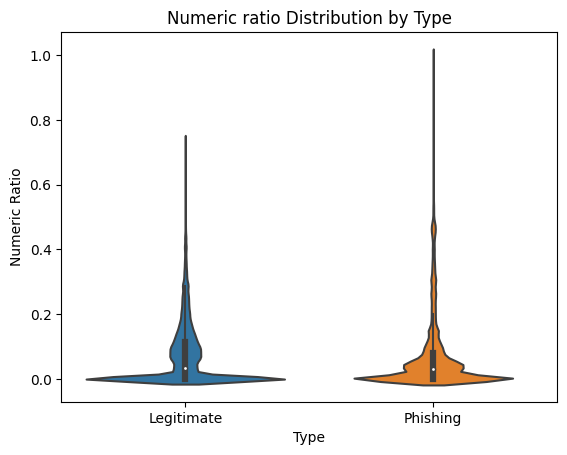

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
# data['count_numbers']
sns.violinplot(x=data['type'], y=data['numeric_ratio'])
plt.title('Numeric ratio Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Numeric Ratio')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

Violin Plot on character ratio and Type EDA 7

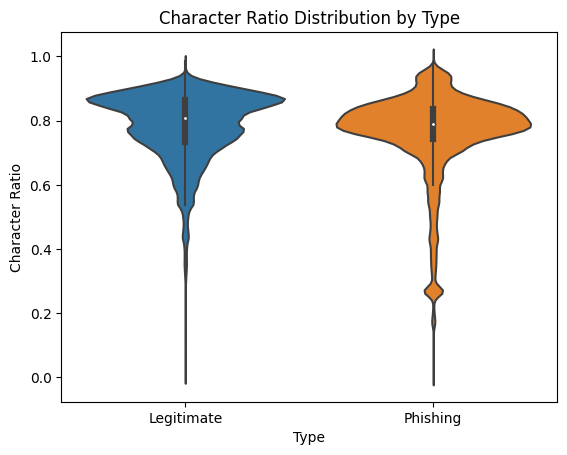

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(x=data['type'], y=data['character_ratio'])
plt.title('Character Ratio Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Character Ratio')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

Stacked Bar Chart special characters vs Type EDA 9

/var/folders/wy/mkqdhcjj11dg3ydn76xg216r0000gn/T/ipykernel_16090/866775000.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('type')['@', '?', '-', '=', '.', '#', '%', '+'].sum().plot(kind='bar', stacked=True)


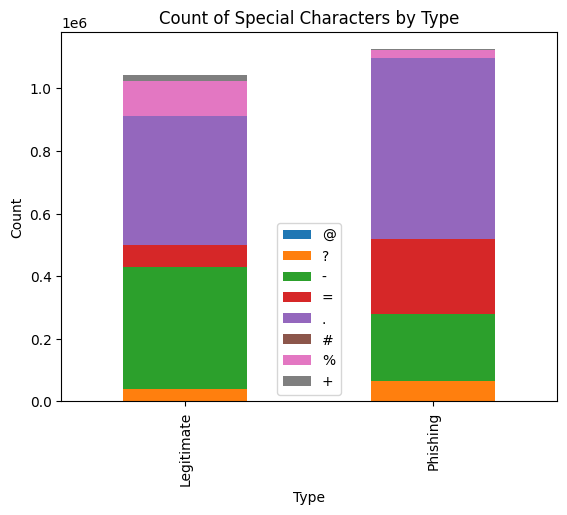

In [258]:
import matplotlib.pyplot as plt
data.groupby('type')['@', '?', '-', '=', '.', '#', '%', '+'].sum().plot(kind='bar', stacked=True)
plt.title('Count of Special Characters by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

Distribution of is ip address attribute EDA 10

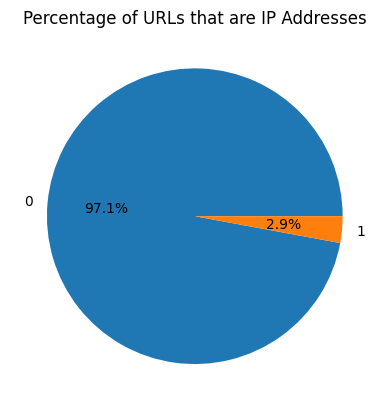

In [259]:
import matplotlib.pyplot as plt
counts = data['is_ip'].value_counts()
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Percentage of URLs that are IP Addresses')
plt.show()

Area plot Length of URL vs Type EDA 11

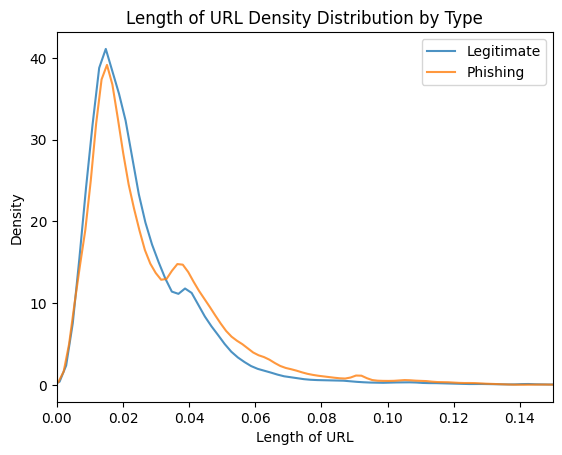

In [260]:
import matplotlib.pyplot as plt
data.groupby('type')['length_of_url'].plot(kind='kde', alpha=0.8)
plt.title('Length of URL Density Distribution by Type')
plt.xlabel('Length of URL')
plt.ylabel('Density')
plt.legend(['Legitimate', 'Phishing'])
plt.xlim(0,0.15)
plt.show()

scatter plot length of URL vs Numeric Ratio EDA 12

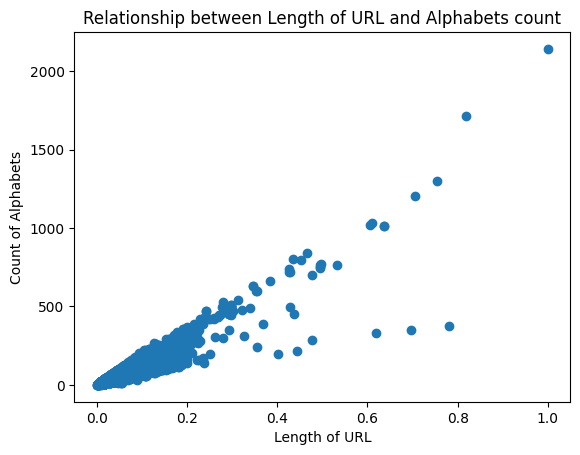

In [261]:
import matplotlib.pyplot as plt
plt.scatter(data['length_of_url'], data['count_alphabets'])
plt.title('Relationship between Length of URL and Alphabets count')
plt.xlabel('Length of URL')
plt.ylabel('Count of Alphabets')
plt.show()

Histogram over distribution of length of url EDA 14

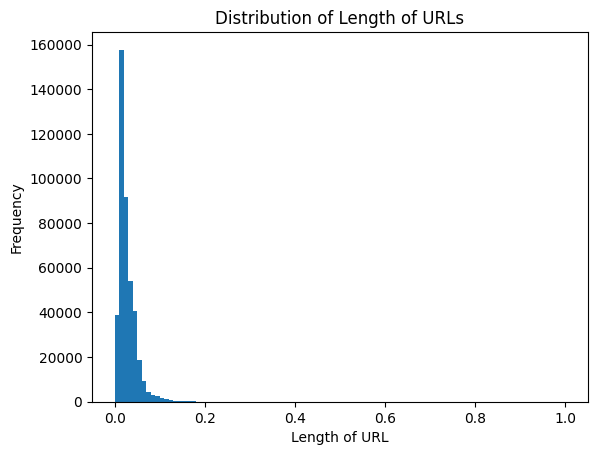

In [262]:
import matplotlib.pyplot as plt
plt.hist(data['length_of_url'], bins=100)
plt.title('Distribution of Length of URLs')
plt.xlabel('Length of URL')
plt.ylabel('Frequency')
plt.show()

Applying Machine Learning Models

In [263]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426078 entries, 598628 to 651190
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   url              426078 non-null  object 
 1   type             426078 non-null  int64  
 2   length_of_url    426078 non-null  float64
 3   @                426078 non-null  int64  
 4   ?                426078 non-null  int64  
 5   -                426078 non-null  int64  
 6   =                426078 non-null  int64  
 7   .                426078 non-null  int64  
 8   #                426078 non-null  int64  
 9   %                426078 non-null  int64  
 10  +                426078 non-null  int64  
 11  $                426078 non-null  int64  
 12  !                426078 non-null  int64  
 13  *                426078 non-null  int64  
 14  ,                426078 non-null  int64  
 15  //               426078 non-null  int64  
 16  abnormal_url     426078 non-null 

In [277]:
datasample = data.copy()

In [278]:
datasample['fld'] = datasample['fld'].replace('invalid',-1)
datasample['fld'] = datasample['fld'].replace('badurl',-1)

datasample['subdomain'] = datasample['subdomain'].replace('invalid',-1)
datasample['subdomain'] = datasample['subdomain'].replace('badurl',-1)

datasample['domain'] = datasample['domain'].replace('invalid',-1)
datasample['domain'] = datasample['domain'].replace('badurl',-1)

datasample['tld'] = datasample['tld'].replace('invalid',-1)
datasample['tld'] = datasample['tld'].replace('badurl',-1)

In [279]:
datasample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426078 entries, 598628 to 651190
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   url              426078 non-null  object 
 1   type             426078 non-null  int64  
 2   length_of_url    426078 non-null  float64
 3   @                426078 non-null  int64  
 4   ?                426078 non-null  int64  
 5   -                426078 non-null  int64  
 6   =                426078 non-null  int64  
 7   .                426078 non-null  int64  
 8   #                426078 non-null  int64  
 9   %                426078 non-null  int64  
 10  +                426078 non-null  int64  
 11  $                426078 non-null  int64  
 12  !                426078 non-null  int64  
 13  *                426078 non-null  int64  
 14  ,                426078 non-null  int64  
 15  //               426078 non-null  int64  
 16  abnormal_url     426078 non-null 

In [280]:
data[['subdomain', 'domain', 'tld', 'fld']]

,subdomain,domain,tld,fld
598628,26,9,3,13
326548,0,21,3,25
318811,0,10,3,14
201748,0,11,3,15
128623,0,11,3,15
...,...,...,...,...
651186,7,3,3,7
651187,5,8,3,12
651188,3,8,3,12
651189,2,9,3,13


TrainTest Split

In [281]:
datasample.isna().sum()

url                0
type               0
length_of_url      0
@                  0
?                  0
-                  0
=                  0
.                  0
#                  0
%                  0
+                  0
$                  0
!                  0
*                  0
,                  0
//                 0
abnormal_url       0
https_scheme       0
count_numbers      0
count_alphabets    0
is_ip              0
subdomain          0
domain             0
tld                0
fld                0
short_url          0
url_path_length    0
numeric_ratio      0
character_ratio    0
dtype: int64

In [287]:
from sklearn.model_selection import train_test_split
X = datasample.iloc[:, 2:].values
Y = datasample.iloc[:, 1]
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

In [288]:
X

array([[0.03311868, 0.        , 0.        , ..., 0.1025641 , 0.        ,
        0.84931507],
       [0.03771849, 0.        , 1.        , ..., 0.02564103, 0.        ,
        0.89156627],
       [0.05565777, 0.        , 1.        , ..., 0.05128205, 0.00819672,
        0.8442623 ],
       ...,
       [0.01885925, 0.        , 0.        , ..., 0.1025641 , 0.07142857,
        0.78571429],
       [0.02023919, 0.        , 0.        , ..., 0.05128205, 0.        ,
        0.8       ],
       [0.01839926, 0.        , 0.        , ..., 0.07692308, 0.        ,
        0.87804878]])

Logistic Regression

In [290]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model object
lr_model = LogisticRegression(solver='lbfgs',max_iter=10000)

# Train the model on the training data
lr_model.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)


In [293]:

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred))

0.9700337964701464


Random Forest

In [292]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model object with 100 trees
rf_model = RandomForestClassifier(n_estimators=100)

# Train the model on the training data
rf_model.fit(X_train, Y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)


Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting model object
gb_model = GradientBoostingClassifier()

# Train the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_model.predict(X_test)


SVM

In [ ]:
from sklearn.svm import SVC

# Create an SVM model object
svm_model = SVC()

# Train the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)


NN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Create a Sequential model object
nn_model = Sequential()

# Add layers to the model
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data
nn_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test data
y_pred = nn_model.predict(X_test)


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree model object
dt_model = DecisionTreeClassifier()

# Train the model on the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)


Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes model object
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb_model.predict(X_test)


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN model object with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_model.predict(X_test)


Light Gradient Boost

In [ ]:
import lightgbm as lgb

# Create a Dataset object from the training data
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for the LightGBM model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 3
}

# Train the model on the training data
lgb_model = lgb.train(params, train_data)

# Make predictions on the test data
y_pred = lgb_model.predict(X_test)


Extreme Gradient Boosting

In [ ]:
import xgboost as xgb

# Create a DMatrix object from the training data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',
    'max_depth': 3
}

# Train the model on the training data
xgb_model = xgb.train(params, dtrain)

# Create a DMatrix object from the test data
dtest = xgb.DMatrix(X_test)

# Make predictions on the test data
y_pred = xgb_model.predict(dtest)


In [120]:
subdmoain = data[data['subdomain']>0]
subdmoain = {}
sns.barplot(x=subdmoain['type'].value_counts().index, y=subdmoain['type'].value_counts())
plt.xlabel('Types')
plt.ylabel('Count')
subdmoain['type'].value_counts()

KeyError: True

Replace strings from domain features with integer values

In [421]:
temp = data
def replace_strings(df, attr):
    df[attr].replace({'invalid':-1, 'badurl':-2}, inplace=True)
    return df
for itr in ['subdomain', 'domain', 'tld', 'fld']:
    temp = replace_strings(temp, itr)
temp.head()

,url,type,length_of_url,@,?,-,=,.,#,%,...,count_alphabets,is_ip,subdomain,domain,tld,fld,short_url,url_path_length,numeric_ratio,character_ratio
0,br-icloud.com.br,1,16,0,0,1,0,2,0,0,...,13,0,0,9,6,16,0,1.0,0.000000,0.812500
1,mp3raid.com/music/krizz_kaliko.html,0,35,0,0,0,0,2,0,0,...,29,0,0,7,3,11,0,3.0,0.028571,0.828571
2,bopsecrets.org/rexroth/cr/1.htm,0,31,0,0,0,0,2,0,0,...,25,0,0,10,3,14,0,4.0,0.032258,0.806452
3,http://www.garage-pirenne.be/index.php?option=...,1,88,0,1,1,4,3,0,0,...,63,0,3,14,2,17,0,2.0,0.079545,0.715909
4,http://adventure-nicaragua.net/index.php?optio...,1,235,0,1,1,3,2,0,0,...,199,0,0,19,3,23,0,2.0,0.093617,0.846809


In [422]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641119 entries, 0 to 651190
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   url              641119 non-null  object 
 1   type             641119 non-null  int64  
 2   length_of_url    641119 non-null  int64  
 3   @                641119 non-null  int64  
 4   ?                641119 non-null  int64  
 5   -                641119 non-null  int64  
 6   =                641119 non-null  int64  
 7   .                641119 non-null  int64  
 8   #                641119 non-null  int64  
 9   %                641119 non-null  int64  
 10  +                641119 non-null  int64  
 11  $                641119 non-null  int64  
 12  !                641119 non-null  int64  
 13  *                641119 non-null  int64  
 14  ,                641119 non-null  int64  
 15  //               641119 non-null  int64  
 16  abnormal_url     641119 non-null  int6